In [2]:
# set to false when no multiprocessing is available
if True:
    import multiprocess as mp
    cpus = 20
    mp.set_start_method("spawn")

In [3]:
#import libraries
import scipy
import seaborn as sns
import matplotlib.font_manager as font_manager
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from scipy.stats import sem
import numpy as np
import hmp 
import xarray as xr
import matplotlib.pyplot as plt
import os
from mne.io import read_info
from datetime import datetime
from statsmodels.stats.descriptivestats import sign_test 
from scipy.stats import ttest_1samp

# get EEG information
epoch_data_path = os.path.join('data/subjects/')                                        #Declaring path where the eeg data is
subj_names = [x.split('.')[0] for x in os.listdir(epoch_data_path) if 'epo.fif' in x]   #Extracting subject name based on the file name
subj_files = [epoch_data_path+x+'.fif' for x in subj_names]                             #Create a list of files that can be read from the folder
info = read_info(subj_files[0], verbose=False)

# load the epoched data and convert to hmp data applying PCA
epoch_data =  hmp.utils.load_data('data/hmp_data/epoch_data.nc')
hmp_data = hmp.utils.transform_data(epoch_data, n_comp=4)

In [4]:
# model initialization parameters to test
parameters = {
    "condition" : ["A", "B", "C", "D"],
    "shape" : [2, 4, 6],
    "location_corr_threshold" : [None, 0.7, 0.4],
    "location_corr_duration" : [200, 300, 400]
}

In [5]:
def get_estimates(shape, location_corr_threshold, location_corr_duration, condition):
    # this if-else-statement only makes the loop execute the model without custom parameters once instead of three times
    if location_corr_threshold == "None" and location_corr_duration != "200":
        return []

    else:
        path_name = "results/conditional/" + condition + "/shape" + str(shape) + \
                    "/location_corr_threshold" + str(location_corr_threshold) + \
                    "/location_corr_duration" + str(location_corr_duration)
        
        return [
            xr.open_dataset(path_name + "/estimates[0].nc"),
            [xr.open_dataset(path_name + "/estimates[1][{0}].nc".format(i)) for i in range (0, 40)]
        ]

In [7]:
def get_piepies(pvalues, steps):
    # count up in events untill an increase in events does not yield a significant improvement.
    for i, (first_value, second_value) in enumerate(pvalues):
        if second_value >= 0.05:
            return i + steps
    return len(pvalues) + steps

In [8]:
def get_max_event(loocv_estimates):
    loocv_estimates = loocv_estimates.dropna('n_event', how='all')

    # difference between event n and n-1
    diffs = [loocv_estimates.sel(n_event=n).data - loocv_estimates.sel(n_event=n-1).data for n in np.arange(2, loocv_estimates.n_event.max()+1)]
    pvalues = [ttest_1samp(diff, 0, alternative='greater') for diff in diffs]

    # difference between event n and n-2
    diffs2 = [loocv_estimates.sel(n_event=n).data - loocv_estimates.sel(n_event=n-2).data for n in np.arange(3, loocv_estimates.n_event.max()+1)]
    pvalues2 = [ttest_1samp(diff, 0, alternative='greater') for diff in diffs2]
    
    # get maximum number of events where p < 0.05
    m = 1
    for i, (first_value, second_value) in enumerate(pvalues):
        if second_value <= 0.05:
            m += 1
    
    # count up in events untill an increase in events does not yield a significant improvement.
    # we also check whether it is signitificantly benefitial to increase the number of events by two.
    if get_piepies(pvalues, 1) != m:
        return get_piepies(pvalues2, 2)
    else:
        return get_piepies(pvalues, 1)
    

In [9]:
def get_mags_pars(models, e):
    #get average mags and params
    mags = models[0].sel(n_events=e).magnitudes.dropna('event')
    params = models[0].sel(n_events=e).parameters.dropna('stage')

    participants = pp = len(np.unique(models[0].participant.values))
    for pp in range(1, participants):
        mags += models[pp].sel(n_events=e).magnitudes.dropna('event')
        params += models[pp].sel(n_events=e).parameters.dropna('stage')
    mags = mags / participants
    params = params / participants

    return mags, params

In [10]:
def general_loocv_model(init, mags, params, e):
    #fit final model
    return init.fit_single(e, magnitudes=mags,parameters=params)

In [15]:
def plot_topos(epoch_data, model, info, init):
    hmp.visu.plot_topo_timecourse(epoch_data, model, info, init, magnify=1, sensors=False, event_lines=True, colorbar=True, contours=0, as_time = True)

In [23]:
def plot_event_probs(estimates, max_events):
    plt.plot(estimates.eventprobs.mean('trial_x_participant'), label=range(1, max_events + 1))
    plt.ylabel('P(event)')
    plt.xlabel('Time (sample)')
    plt.legend()
    plt.show()

C shape, location_corr_threshold, location_corr_duration, max_events, likelihood
A 2      None                     200                             4            -19.2


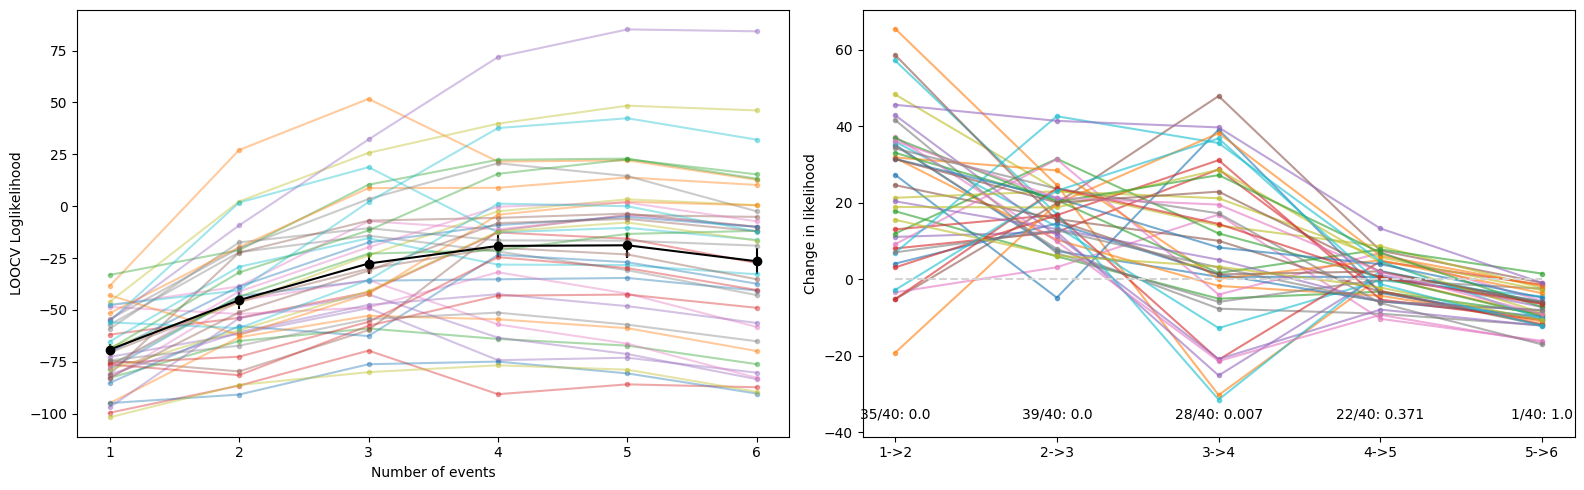

Estimating 4 events model
parameters estimated for 4 events model


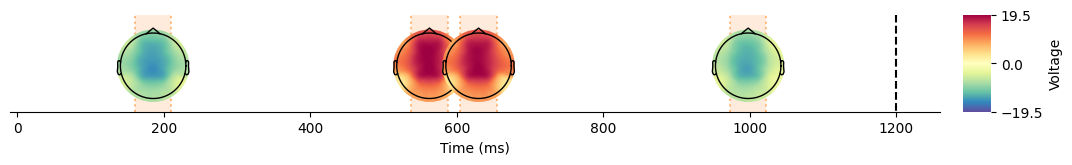

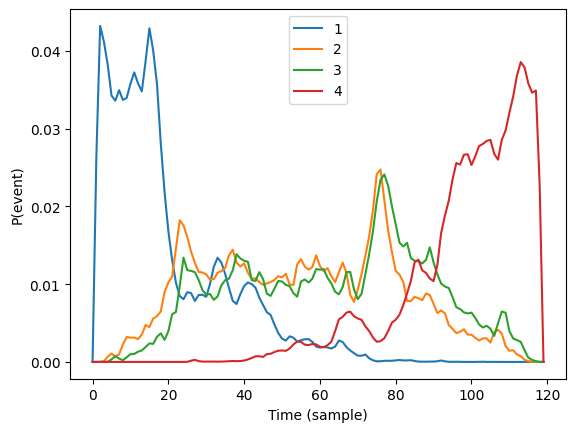

We recommend using cpus==1 unless you have *a lot* of memory and cpus available.
Estimating 4 events model
Estimating 4 events model
Estimating 4 events model
parameters estimated for 4 events model
Estimating 4 events model
parameters estimated for 4 events model
Estimating 4 events model
parameters estimated for 4 events model
parameters estimated for 4 events model
Estimating 4 events model
Estimating 4 events model
parameters estimated for 4 events model
parameters estimated for 4 events model
Estimating 4 events model
parameters estimated for 4 events model
Estimating 4 events model
Estimating 4 events model
parameters estimated for 4 events model
parameters estimated for 4 events model
Estimating 4 events model
Estimating 4 events model
parameters estimated for 4 events model
Estimating 4 events model
Estimating 4 events model
parameters estimated for 4 events model
parameters estimated for 4 events model
parameters estimated for 4 events model
Estimating 4 events model
parameter

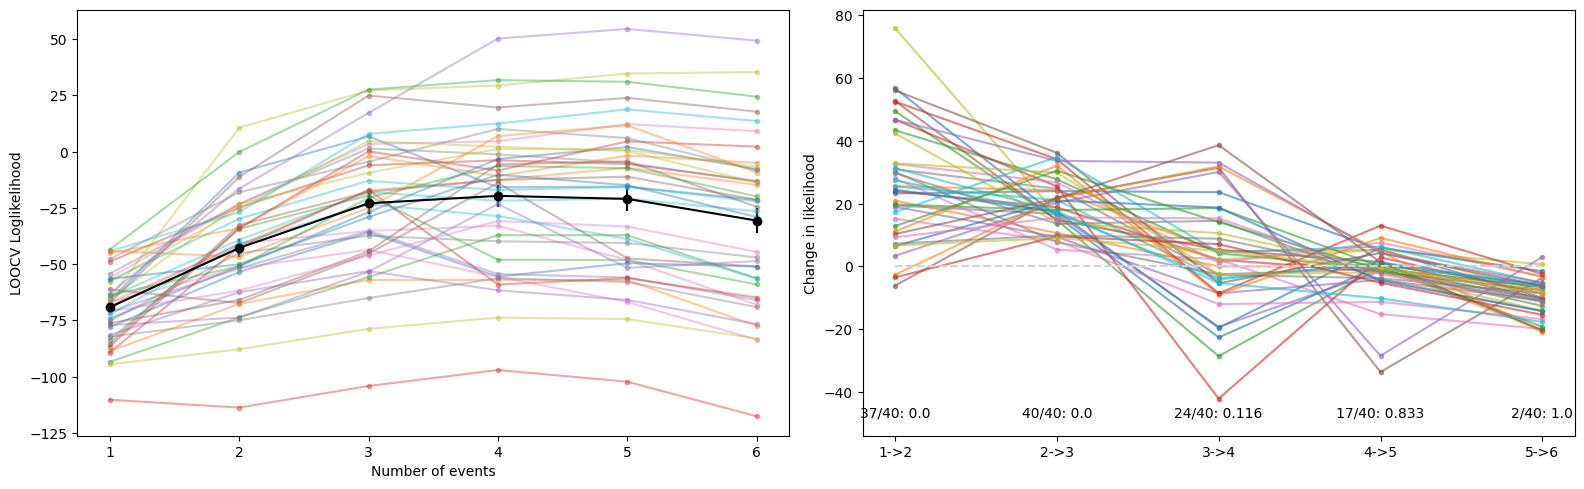

Estimating 3 events model
parameters estimated for 3 events model


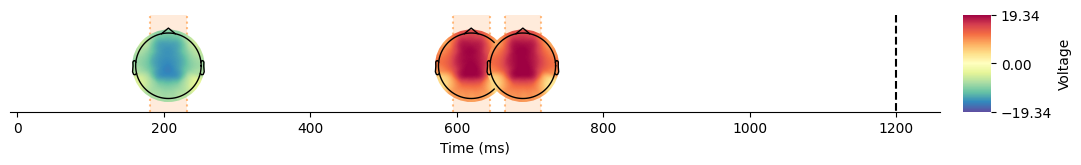

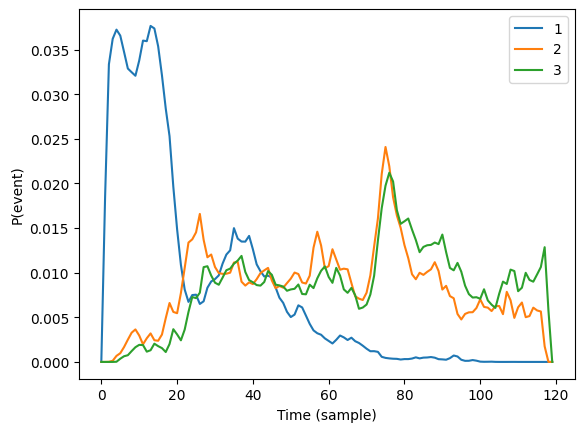

We recommend using cpus==1 unless you have *a lot* of memory and cpus available.
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
Estimating 3 events model
parameters estimated for 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
Estimating 3 events model
parameter

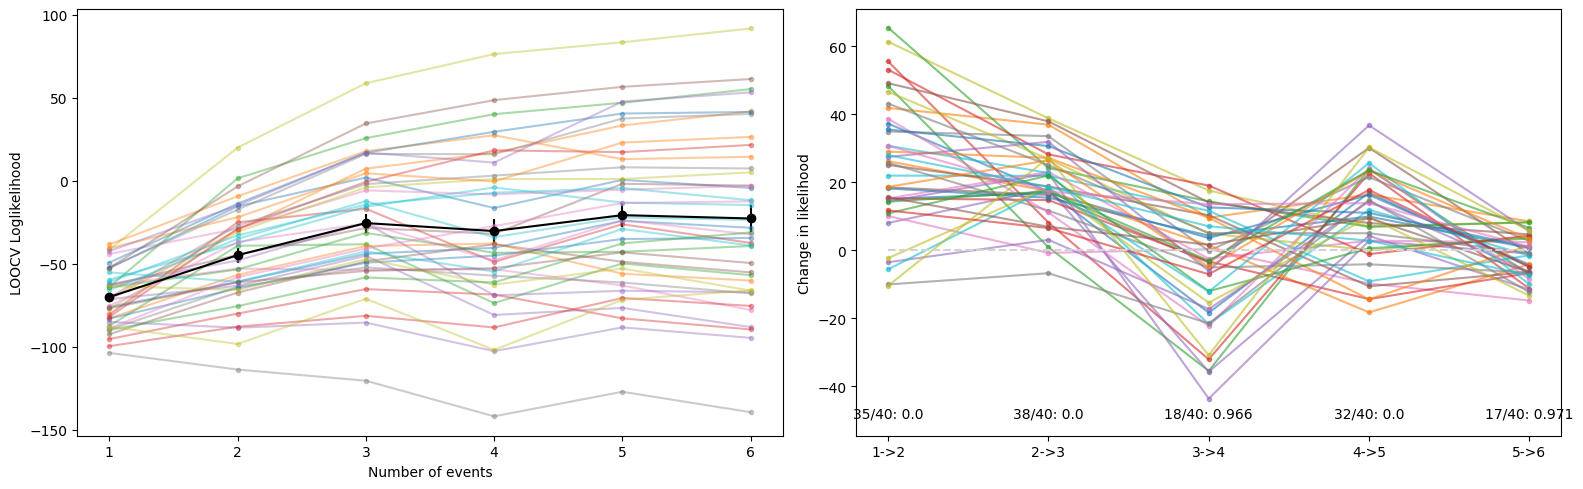

Estimating 5 events model
parameters estimated for 5 events model


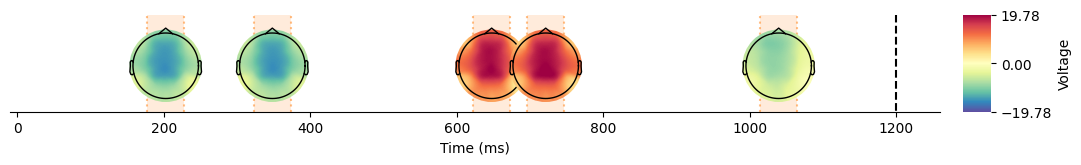

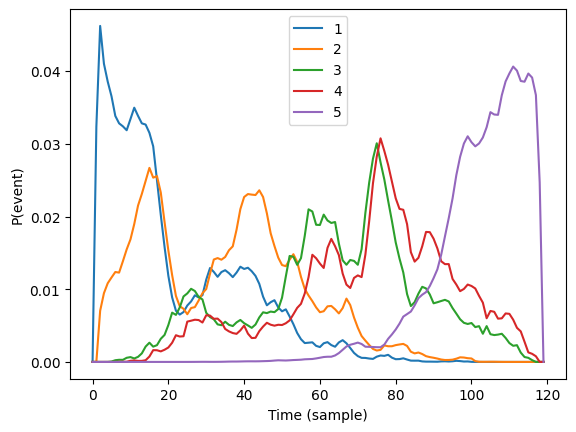

We recommend using cpus==1 unless you have *a lot* of memory and cpus available.
Estimating 5 events model
Estimating 5 events model
Estimating 5 events model
parameters estimated for 5 events model
Estimating 5 events model
parameters estimated for 5 events model
Estimating 5 events model
Estimating 5 events model
parameters estimated for 5 events model
Estimating 5 events model
parameters estimated for 5 events model
parameters estimated for 5 events model
Estimating 5 events model
parameters estimated for 5 events model
Estimating 5 events model
parameters estimated for 5 events model
parameters estimated for 5 events model
Estimating 5 events model
Estimating 5 events model
parameters estimated for 5 events model
Estimating 5 events model
parameters estimated for 5 events model
Estimating 5 events model
Estimating 5 events model
parameters estimated for 5 events model
parameters estimated for 5 events model
Estimating 5 events model
parameters estimated for 5 events model
Estimatin

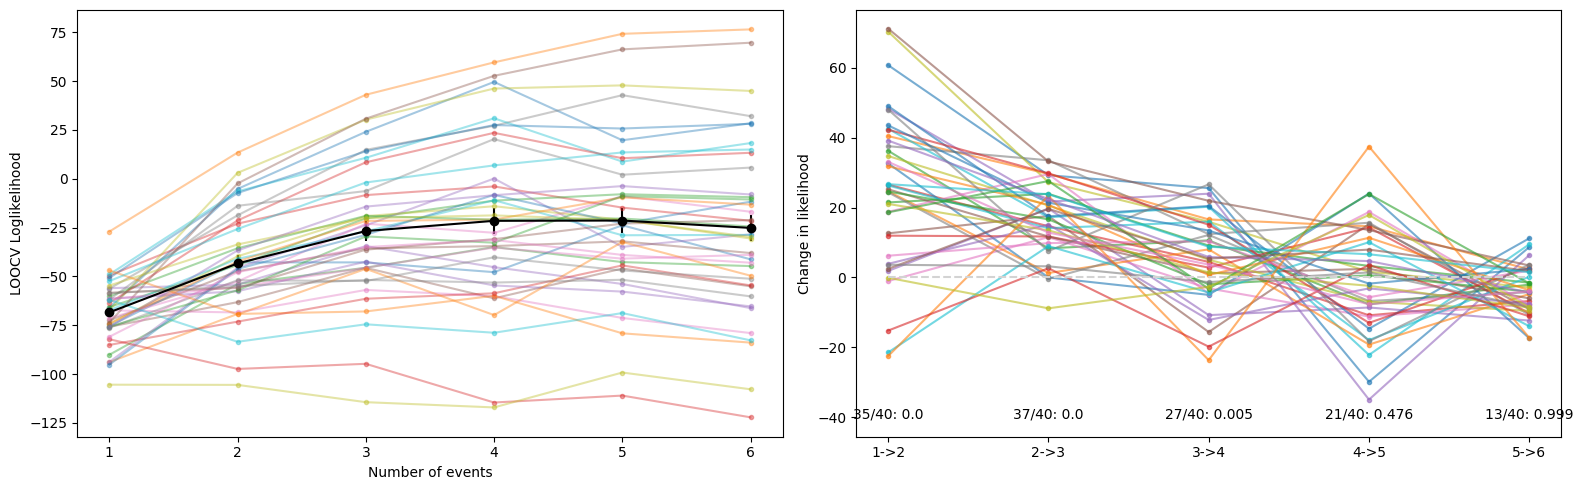

Estimating 4 events model
parameters estimated for 4 events model


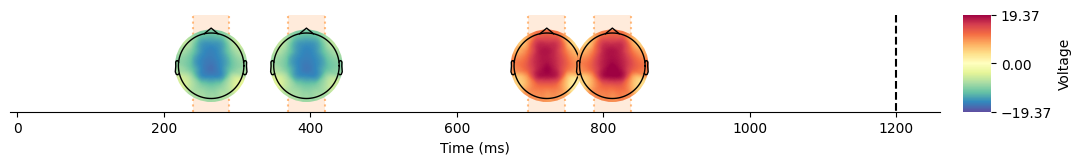

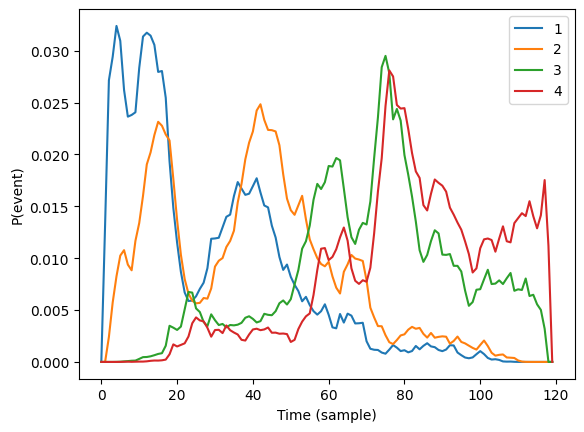

We recommend using cpus==1 unless you have *a lot* of memory and cpus available.
Estimating 4 events model
Estimating 4 events model
Estimating 4 events model
parameters estimated for 4 events model
parameters estimated for 4 events model
Estimating 4 events model
parameters estimated for 4 events model
Estimating 4 events model
parameters estimated for 4 events model
Estimating 4 events model
parameters estimated for 4 events model
Estimating 4 events model
Estimating 4 events model
parameters estimated for 4 events model
parameters estimated for 4 events model
Estimating 4 events model
parameters estimated for 4 events model
Estimating 4 events model
parameters estimated for 4 events model
Estimating 4 events model
Estimating 4 events model
parameters estimated for 4 events model
Estimating 4 events model
parameters estimated for 4 events model
Estimating 4 events model
parameters estimated for 4 events model
parameters estimated for 4 events model
Estimating 4 events model
parameter

TypeError: type DataArray doesn't define __round__ method

In [26]:
print("C shape, location_corr_threshold, location_corr_duration, max_events, likelihood")
for shape in parameters["shape"]:
    for location_corr_threshold in parameters["location_corr_threshold"]:
        for location_corr_duration in parameters["location_corr_duration"]:
            likelihoods_sum = np.zeros(40)
            for condition in parameters["condition"]:
                # remove the following if statement to run the code for all paramater combinations
                if shape == 2 and location_corr_threshold == None and location_corr_duration == 200:
                    estimates = get_estimates(str(shape), str(location_corr_threshold), str(location_corr_duration), condition)
                    if estimates:
                        max_events = get_max_event(estimates[0]["loo_likelihood"])
                        likelihoods_sum += estimates[0]["loo_likelihood"].sel(n_event = max_events).data

                        means = np.nanmean(estimates[0]["loo_likelihood"].data,axis=1)[::-1]
                        print(condition + " {0:6} {1:24} {2:22} {3:10} {4:16}".format(str(shape), str(location_corr_threshold), str(location_corr_duration), max_events, round(means[max_events - 1], 1)))
                        if means[max_events - 1] > -100:
                            hmp.visu.plot_loocv(estimates[0]["loo_likelihood"], pvals=True, test='t-test', indiv=True, mean=True)
                            mags, params = get_mags_pars(estimates[1], max_events)
                            hmp_data_cond = hmp.utils.condition_selection(hmp_data, epoch_data, condition, variable='event_name')

                            init = hmp.models.hmp(hmp_data_cond, epoch_data, event_width=50, cpus=cpus, 
                                                    shape =                   shape,
                                                    location_corr_threshold = location_corr_threshold,
                                                    location_corr_duration  = location_corr_duration)

                            # fit model
                            general_model = general_loocv_model(init, mags, params, max_events)

                            # plot topology of model
                            plot_topos(epoch_data, general_model, info, init)
                            plot_event_probs(general_model, max_events)

                            # general_model_likelihoods = hmp.loocv.loocv(init, hmp_data, general_model, cpus = cpus, verbose = False)
                            general_model_likelihoods = hmp.loocv.loocv_func(init, hmp_data_cond, general_loocv_model, func_args = [mags, params, max_events], cpus = cpus, verbose = False)

                            print(np.mean(general_model_likelihoods[0]))
                            likelihoods_sum += general_model_likelihoods[0]
            print("sum likelihoods over conditions " + str(round(np.mean(likelihoods_sum), 1)))
                    
